![Fixel Algorithms](https://fixelalgorithms.co/images/CCExt.png)

# <center> Machine Learning Methods </center>
## <center> Lecture 24 - Time Series Analysis</center>
### <center> SARIMA </center>

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/FixelAlgorithmsTeam/FixelCourses/blob/master/MachineLearningMethod/24_TimeSeries/MainSARIMA.ipynb)

In [1]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt

#### An auxiliary plot function to analyze the residuals $e_n$:

In [2]:
from scipy.stats                   import gaussian_kde, norm
from statsmodels.graphics.gofplots import qqplot
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic  import acorr_ljungbox

def PlotResidual(vEn, fig):
    std     = np.std        (vEn)
    oKde    = gaussian_kde  (vEn)
    _, pVal = acorr_ljungbox(vEn, [40], return_df=False) #-- white noise test
    pVal    = pVal[-1]

    #-- Plot error signal:
    x  = np.arange(len(vEn))
    ax = fig.add_subplot(2, 1, 1)
    ax.stem      (x, vEn, use_line_collection=True, label='$e_n$')
    ax.set_title (f'$\mu_e = {np.mean(vEn):.3f}$, $\sigma_e = {std:.3f}$')
    ax.set_xlabel('$n$')
    ax.set_xlim  (x[0], x[-1])
    plt.legend   ()

    #-- Plot historgram:
    xlim = (-3*std, 3*std)
    x    = np.linspace(xlim[0], xlim[1])
    ax   = fig.add_subplot(2,2,3)
    ax.hist     (vEn, density=True, color='c', edgecolor='k', label='Hist')
    ax.plot     (x, oKde(x),                                  label='KDE')
    ax.plot     (x, norm.pdf(x, 0, std),                      label='$\mathcal{N}(0,\sigma^2)$')
    ax.set_title('Density estimation')
    ax.set_xlim (xlim)
    ax.legend   ()
    
    #-- Plot auto-correlation function (ACF):
    ax = fig.add_subplot(2,2,4)
    plot_acf     (vEn, ax=ax, lags = 20, adjusted=True, label='$\hat{\\rho}_{e}[k]$')
    ax.set_title (f'white noise test: $p = {pVal:.5f}$')
    ax.set_xlabel('$k$')
    plt.legend   ()

    plt.tight_layout()

    return fig

#### Load data:
And split to train and test

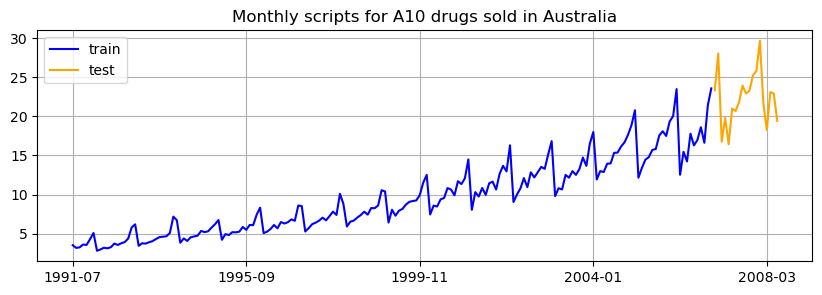

In [3]:
dData = pd.read_csv('./a10.csv')
vX    = dData.x.values
Dates = np.arange('1991-07', '2008-07', dtype='datetime64[M]')
N     = len(vX)

vIdx    = np.arange(N)
Ntrain  = 185
vTrainX = vX[:Ntrain]
vTestX  = vX[Ntrain:]

#-- Plotting data
plt.figure(figsize=(10, 3))
plt.plot  (vIdx[:Ntrain], vTrainX, 'b',      label='train')
plt.plot  (vIdx[Ntrain:], vTestX,  'orange', label='test')
plt.title ('Monthly scripts for A10 drugs sold in Australia')
plt.xticks(vIdx[::50], Dates[::50])
plt.legend(loc='upper left')
plt.grid  ()
plt.show  ()

#### Apply $\log(\cdot)$ to adjust variance:

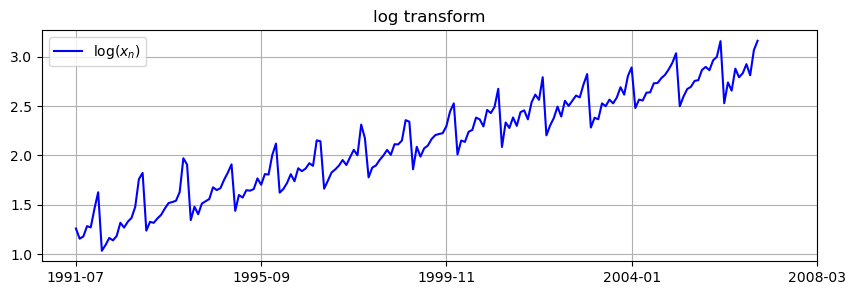

In [4]:
vLogTrainX = np.log(vTrainX)

#-- Plotting data
plt.figure(figsize=(10, 3))
plt.plot  (vIdx[:Ntrain], vLogTrainX, 'b', label='$\log(x_n)$')
plt.title ('log transform')
plt.xticks(vIdx[::50], Dates[::50])
plt.legend(loc=2)
plt.grid  ()
plt.show  ()

#### Plot ACF and PACF:
Applied to $\log(x_n)$

C:\Users\oryai\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1998: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


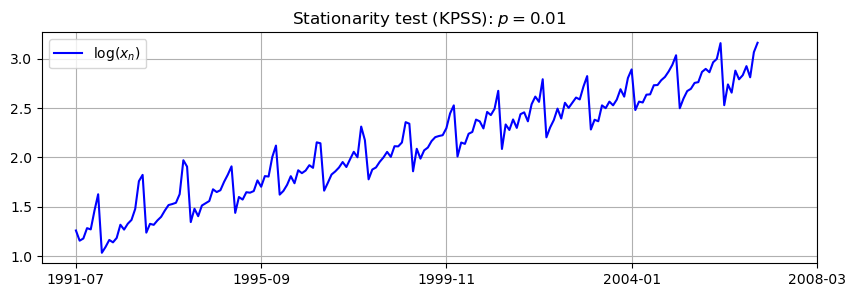

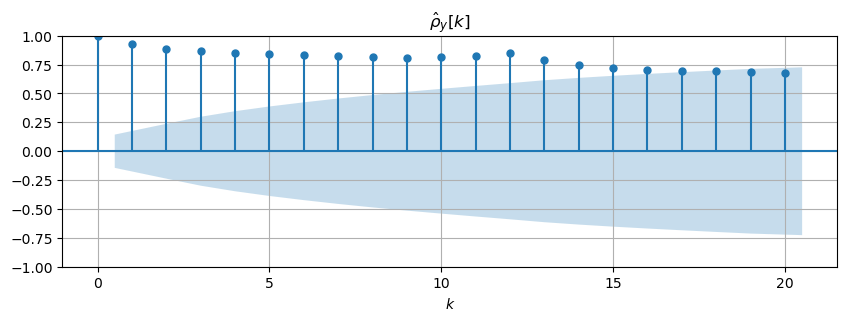

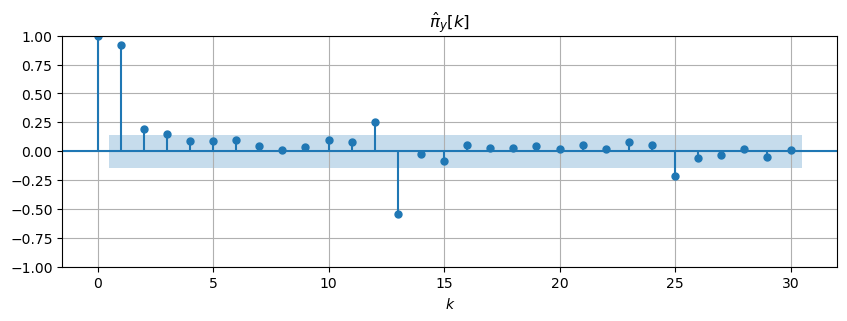

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools     import kpss

pVal = kpss(vLogTrainX, nlags='auto')[1] #-- stationarity test

#-- Plotting data
plt.figure(figsize=(10, 3))
plt.plot  (vIdx[:Ntrain], vLogTrainX, 'b', label='$\log(x_n)$')
plt.title (f'Stationarity test (KPSS): $p = {pVal}$')
plt.xticks(vIdx[::50], Dates[::50])
plt.legend(loc=2)
plt.grid  ()

#-- ACF & PACF
_, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf  (vLogTrainX, lags=20, adjusted=True, ax=ax)
plt.title ('$\hat{\\rho}_y[k]$')
plt.xlabel('$k$')
plt.grid  ()

_, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_pacf (vLogTrainX, lags=30, ax=ax, method='ywm')
plt.title ('$\hat{\pi}_y[k]$')
plt.xlabel('$k$')
plt.grid  ()
plt.show  ()

### Seasonal differencing ($S=12$):
$$\tilde{X}_{n}=X_{n}-X_{n-S}$$

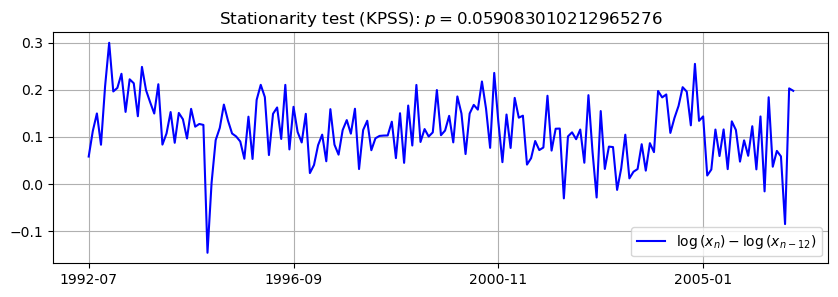

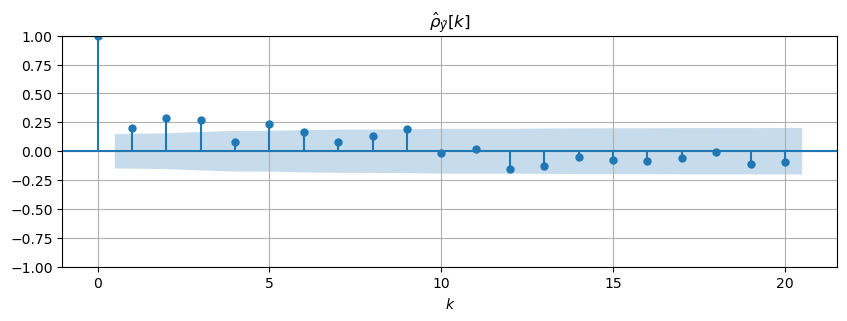

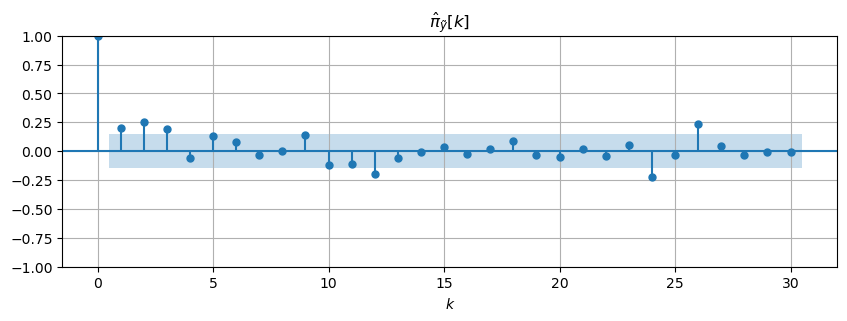

In [6]:
S      = 12
vDlogX = vLogTrainX[S:] - vLogTrainX[:-S]
pVal   = kpss(vDlogX, nlags='auto')[1] #-- stationarity test

#-- Plotting data
plt.figure(figsize=(10, 3))
plt.plot  (vIdx[S:Ntrain], vDlogX, 'b', label=r'$\log\left(x_{n}\right)-\log\left(x_{n-12}\right)$')
plt.title (f'Stationarity test (KPSS): $p = {pVal}$')
plt.xticks(np.arange(S, N, 50), Dates[S::50])
plt.legend()
plt.grid  ()

#-- ACF & PACF
_, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_acf  (vDlogX, lags=20, adjusted=True, ax=ax)
plt.title ('$\hat{\\rho}_{\\tilde{y}}[k]$')
plt.xlabel('$k$')
plt.grid  ()

_, ax = plt.subplots(1, 1, figsize=(10, 3))
plot_pacf (vDlogX, lags=30, ax=ax, method='ywm')
plt.title('$\hat{\pi}_{\\tilde{y}}[k]$')
plt.xlabel('$k$')
plt.grid  ()
plt.show  ()

#### Train multiple SARIMA models (and choose the best one):
$S$, $d$, and $D$ need to be set manually

In [7]:
from statsmodels.tsa.statespace import sarimax

#-- Fixed params:
S  = 12
d  = 0
D  = 1

#-- Grid search:
vp = np.arange(3)
vq = np.arange(3)
vP = np.arange(3)
vQ = np.arange(3)

T  = pd.DataFrame(columns=['p', 'q', 'P', 'Q', 'AIC', 'BIC'])
for pp in vP:
    for qq in vQ:
        for PP in vP:
            for QQ in vQ:
                oModel        = sarimax.SARIMAX(vLogTrainX, order=(pp,d,qq), seasonal_order=(PP,D,QQ,S), trend='c').fit(maxiter=100)
                T.loc[len(T)] = [pp, qq, PP, QQ, oModel.aic, oModel.bic] 

T.sort_values(by='AIC')

C:\Users\oryai\anaconda3\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\oryai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\oryai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\oryai\anaconda3\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\oryai\anaconda3\lib\site-packages\statsmode

,p,q,P,Q,AIC,BIC
65,2.0,1.0,0.0,2.0,-498.198548,-476.125507
47,1.0,2.0,0.0,2.0,-497.945591,-475.872549
38,1.0,1.0,0.0,2.0,-496.536678,-477.616928
56,2.0,0.0,0.0,2.0,-495.445558,-476.525808
68,2.0,1.0,1.0,2.0,-495.156420,-469.930087
...,...,...,...,...,...,...
4,0.0,0.0,1.0,1.0,-449.894326,-437.281159
0,0.0,0.0,0.0,0.0,-448.693707,-442.387124
17,0.0,1.0,2.0,2.0,-444.704933,-422.631892
8,0.0,0.0,2.0,2.0,-440.720721,-421.800971


### Training a single SARIMA model:

In [8]:
#-- SARIMA(p,d,q)(P,D,Q,S) with constnat model:
p = 2
q = 1
P = 0
Q = 2
oTrainModel = sarimax.SARIMAX(
    vLogTrainX,
    order          = (p,d,q),
    seasonal_order = (P,D,Q,12),
    trend          = 'c'
)
oTrainModel = oTrainModel.fit(maxiter=1000)
oTrainModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  185
Model:             SARIMAX(2, 0, 1)x(0, 1, [1, 2], 12)   Log Likelihood                 256.099
Date:                                 Tue, 02 Nov 2021   AIC                           -498.199
Time:                                         16:10:25   BIC                           -476.126
Sample:                                              0   HQIC                          -489.244
                                                 - 185                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0304      0.017      1.813      0.070      -0.002       0.063
ar.L1          0.4863      0.228      2.133      0.033       0.039       0.933
ar.L2          0.2431      0.105      2.305      0.021       0.036       0.450
ma.L1         -0.3660      0.244     -1.503      0.133      -0.843       0.111
ma.S.L12      -0.4525      0.089     -5.112      0.000      -0.626      -0.279
ma.S.L24      -0.3445      0.105     -3.278      0.001      -0.551      -0.139
sigma2         0.0028      0.000      8.824      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 3.72
Prob(Q):                              0.90   Prob(JB):                         0.16
Heteroskedasticity (H):               1.02   Skew:                            -0.19
Prob(H) (two-sided):                  0.94   Kurtosis:                         3.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Plot error (residual) statistics:

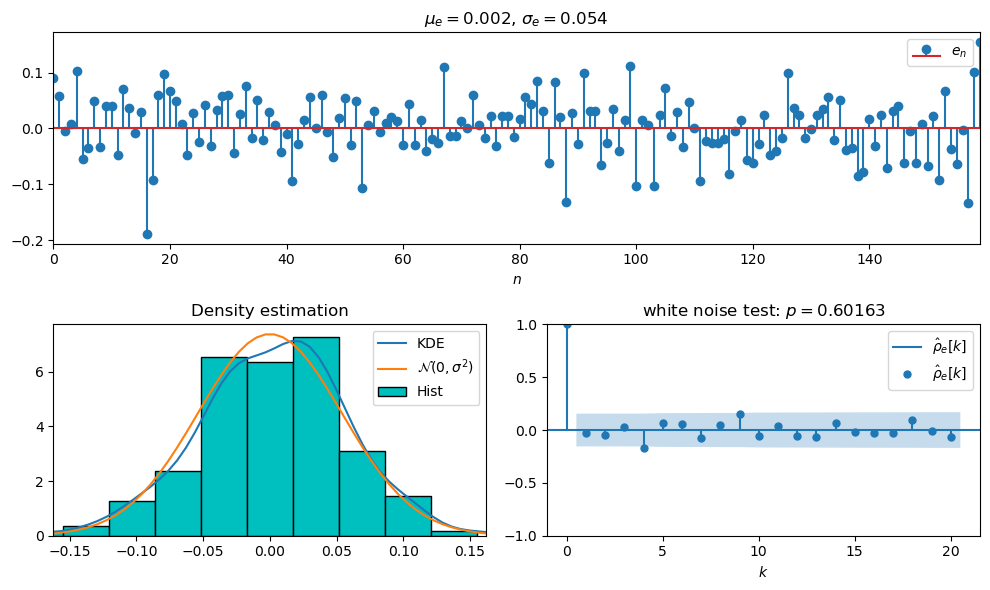

In [9]:
#-- One step prediction (train set):
start = 25
oPred = oTrainModel.get_prediction(start=start, end=Ntrain-1, dynamic=False)

#-- Residuals:
En    = vLogTrainX[start:] - oPred.predicted_mean

fig = plt.figure(figsize=(10, 6))
PlotResidual(En, fig)
plt.show    ()

#### Predict (forecast):
Predict on train, test (one step), and long test (future forecast)

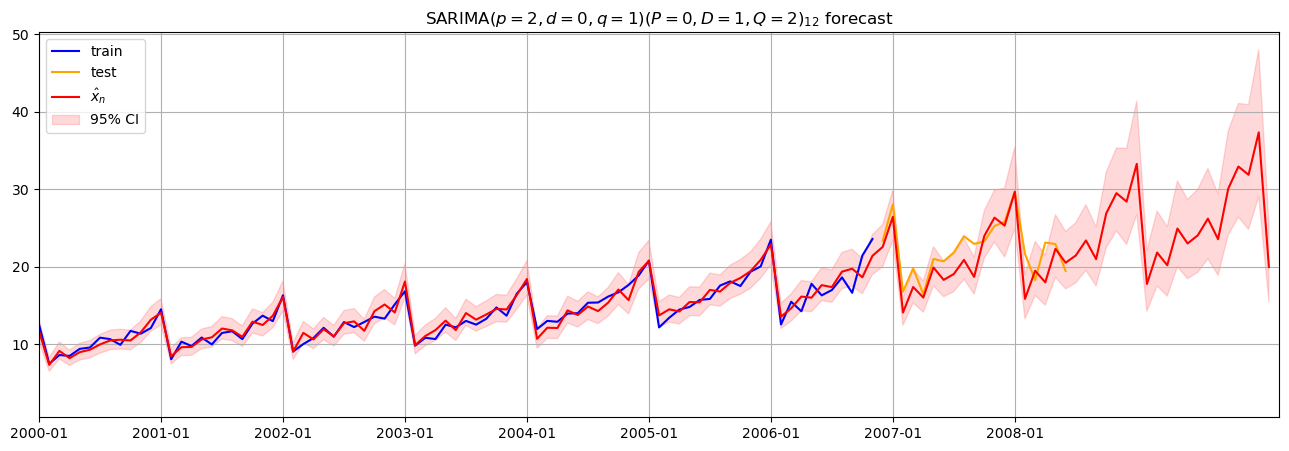

In [10]:
#-- Add test data to the model:
oTestModel = sarimax.SARIMAX(np.log(vX), order=(p,d,q), seasonal_order=(P,D,Q,S), trend='c')
oTestModel = oTestModel.filter(oTrainModel.params)

#-- One step prediction (train), Dynamic forecast (test):
Np    = 20
oPred = oModel.get_prediction(start, N - 1 + Np, Ntrain - start)
vHatX = oPred.predicted_mean

#-- Confidence intervals, α = 0.05 (95%):
pred_ci = oPred.conf_int(alpha=0.05)

#-- Inverse log (exp):
vHatX        = np.exp(vHatX)
pred_ci[:,0] = np.exp(pred_ci[:,0])
pred_ci[:,1] = np.exp(pred_ci[:,1])

#-- Plot:
vPredIdx = np.arange(start, N + Np)
plt.figure      (figsize=(16, 5))
plt.plot        (vIdx[:Ntrain], vTrainX, 'b',     lw=1.5, label='train')
plt.plot        (vIdx[Ntrain:], vTestX,  'orange',lw=1.5, label='test')
plt.plot        (vPredIdx,      vHatX,   'r',     lw=1.5, label='$\hat{x}_n$')
plt.fill_between(vPredIdx, pred_ci[:,0], pred_ci[:,1], color='r', alpha=.15, label = '95% CI')
plt.title       ('SARIMA($p=%d,d=%d,q=%d$)($P=%d,D=%d,Q=%d)_{%d}$ forecast' % (p,d,q,P,D,Q,S))
plt.xticks      (vIdx[6::12], Dates[6::12])
plt.xlim        ([N/2, N+Np])
plt.legend      (loc='upper left')
plt.grid        ()
plt.show        ()